# Comparing Total Gas Masses Between Analyses - XXL-100-GC

This notebook measures gas masses for the XXL-100-GC sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xxlgc100_colour, xxl_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

In [2]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:05<09:40,  5.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                             | 2/99 [00:13<10:57,  6.78s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  17%|███████▋                                     | 17/99 [01:21<06:05,  4.46s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-98 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  18%|████████▏                                    | 18/99 [01:25<05:47,  4.29s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-99 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  19%|████████▋                                    | 19/99 [01:29<05:41,  4.27s/it]/mnt/pact/dt23

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-25 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  34%|███████████████▍                             | 34/99 [04:15<17:14, 15.91s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-41 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  35%|███████████████▉                             | 35/99 [04:40<20:01, 18.77s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-50 has not been detected in all regi

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-104 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  47%|█████████████████████▎                       | 47/99 [06:50<07:48,  9.01s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-88 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  48%|█████████████████████▊                       | 48/99 [06:57<07:18,  8.60s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-87 has not been detected in all reg

Setting up Galaxy Clusters:  64%|████████████████████████████▋                | 63/99 [07:50<01:15,  2.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-534 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  65%|█████████████████████████████                | 64/99 [07:53<01:20,  2.31s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-517 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  66%|█████████████████████████████▌               | 65/99 [07:55<01:18,  2.30s/it]/mnt/pact/dt

Setting up Galaxy Clusters:  80%|███████████████████████████████████▉         | 79/99 [08:37<00:49,  2.46s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-512 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  81%|████████████████████████████████████▎        | 80/99 [08:40<00:49,  2.62s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  82%|████████████████████████████████████▊        | 81/99 [08:42<00:42,  2.36s/it]/mnt/pact/dt

Setting up Galaxy Clusters:  98%|████████████████████████████████████████████ | 97/99 [09:41<00:08,  4.06s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-510 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  99%|████████████████████████████████████████████▌| 98/99 [09:44<00:03,  3.61s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-511 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 99/99 [09:45<00:00,  5.92s/it]


In [4]:
del xxl_srcs['XLSSC-11']

## Running PSF Correction

In [5]:
rl_psf(xxl_srcs)

Generating products of type(s) image: 100%|███████████████████████████████████| 88/88 [00:05<00:00, 16.17it/s]


## Reading in literature data

### Gas masses from literature

In [6]:
xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err']].values*1e+13 
               for n in xxl_srcs.names]
xxl_lit_gms = Quantity(xxl_lit_gms, 'Msun')

### Conversion Temperatures

In [7]:
xxl_conv_txs = []

for src in xxl_srcs:
    xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
xxl_conv_txs = Quantity(xxl_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to $R_{500}$

In [8]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [9]:
xxl_beta_1r500_dp = inv_abel_fitted_model(xxl_srcs, 'beta', 'mcmc', xxl_srcs.r500, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 96/96 [00:18<00:00,  5.12it/s]
Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 14/96 [04:49<28:43, 21.01s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 32/96 [11:21<23:19, 21.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 227.83641712 1140.23465668 1022.16953863]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 43/96 [15:26<18:56, 21.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [139.97820357 298.924749   719.13363399]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/96 [21:10<13:11, 21.40s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 66/96 [23:30<10:13, 20.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [437.23196132 465.81445792 239.76166111]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 82/96 [29:17<05:00, 21.46s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-507's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 86/96 [30:39<03:27, 20.78s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/

In [10]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [11]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_beta_1r500_dp)) as onwards:
    for dp in xxl_beta_1r500_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)


Fitting density model to XXL profiles:  32%|██████████▉                       | 31/96 [15:48<34:34, 31.91s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1012: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
Fitting density model to XXL profiles: 100%|██████████████████████████████████| 96/96 [48:43<00:00, 30.45s/it]


In [21]:
xxl_beta_king_1r500_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_beta_1r500_dp)) as onwards:
    for dp in xxl_beta_1r500_dp:
        if dp is not None:
            gm = dp.gas_mass("king", xxl_srcs[dp.src_name].r500)[0]
            xxl_beta_king_1r500_gm.append(gm)
        else:
            xxl_beta_king_1r500_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_beta_king_1r500_gm = Quantity(xxl_beta_king_1r500_gm, 'Msun')

Calculating XXL gas masses:   0%|                                                      | 0/96 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/profile.py:475: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  warn("The outer radius you supplied is greater than or equal to the outer radius covered by the data, so"
Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 96/96 [00:05<00:00, 17.31it/s]


In [22]:
print("{s} out of {t} gas mass measurements produced a "\
      "result".format(s=np.isfinite(xxl_beta_king_1r500_gm[:, 0]).sum(), t=len(xxl_beta_king_1r500_gm)))

92 out of 96 gas mass measurements produced a result


This section deals with two data problems, one with the literature XXL values (where an XXL gas mass is smaller than its uncertainty - messes up the plot), and another with an XGA measurement. This measurement was very low mass, and again was messing up the plot. I have made this section print the name of the cluster with this problem, but it is also removed from the gas mass array to improve the look of the figure.

In [37]:
if np.any((xxl_lit_gms[:, 0] - xxl_lit_gms[:, 1]) < 0):
    xxl_lit_gms[np.argmin((xxl_lit_gms[:, 0] - xxl_lit_gms[:, 1]))] = Quantity([np.NaN, np.NaN], 'Msun')

if len(xxl_beta_king_1r500_gm[xxl_beta_king_1r500_gm < Quantity(1e+9, 'Msun')]) != 0:
    which_low = np.where(xxl_beta_king_1r500_gm[:, 0] < Quantity(1e+9, 'Msun'))[0]
    print(xxl_srcs.names[which_low])
    xxl_beta_king_1r500_gm[which_low] = np.NaN

['XLSSC-54']


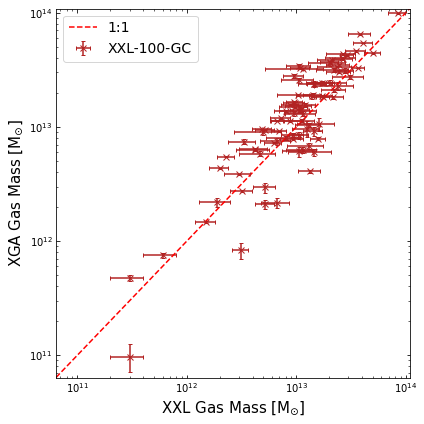

In [38]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_beta_king_1r500_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_beta_king_1r500_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_beta_king_1r500_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("../../outputs/figures/xxl_beta_king_1r500_gm_comp.pdf")
plt.show()
plt.close('all')

### Double Beta and Simplified Vikhlinin Profiles - out to $R_{500}$

In [24]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [25]:
xxl_dblbeta_1r500_dp = inv_abel_fitted_model(xxl_srcs, 'double_beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/96 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-94's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   1%|        | 1/96 [00:20<32:16, 20.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [459.1605528  828.11030928 818.9421291  566.81779022 722.03232424
 763.4941998 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-96's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 2/96 [00:42<33:29, 21.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 359.00553169  673.94504675 1128.68381341  312.89364222  477.58023087
  992.3424125 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-102's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   3%|▎       | 3/96 [01:03<32:50, 21.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 277.06792436  587.7606687  1373.14060914  201.24245235  267.76918858
 1182.3948439 ]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 4/96 [01:26<33:21, 21.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 436.64578203 1024.09023285 1648.84719727  699.96290219  853.55904578
 1531.84556943]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-107's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 5/96 [01:46<32:31, 21.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [414.12687679 757.76457369 988.35151149 254.30302884 364.98481713
 936.58132514]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-100's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   6%|▌       | 6/96 [02:07<31:44, 21.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [376.99994029 955.16931367 733.92929573 359.54306623 661.49514377
 695.39380558]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-93's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 7/96 [02:29<31:47, 21.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 387.40221454  731.36475061 1257.33965124  524.07351332  821.6135627
 1131.56958712]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-108's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   8%|▋       | 8/96 [02:51<31:30, 21.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 512.77628293 1896.18295064 2162.43958794  240.01222092  364.53581272
 1832.23521234]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-95's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   9%|▊       | 9/96 [03:11<30:46, 21.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [347.14927289 644.03414254 708.60475059 474.01824138 488.70001349
 572.40140004]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-92's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  10%|▋      | 10/96 [03:32<30:23, 21.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 523.18125952 1064.36230381 1749.98981526  249.86667972  383.79154439
 1343.98468557]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▊      | 11/96 [03:54<30:08, 21.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [417.08513285 654.07815121 599.62659557 480.73268503 781.12648233
 681.12695745]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▉      | 12/96 [04:15<29:45, 21.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [235.16294262 563.35171578 475.4544665  284.65571767 479.31912663
 477.27348305]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-112's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  14%|▉      | 13/96 [04:39<30:28, 22.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 546.54675194 1853.76730196 2251.70006059  405.12255847  645.83409279
 2147.74105452]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-83's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 14/96 [05:01<30:02, 21.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 292.49950987 1014.15720867  948.59893644  420.29391004  832.96561695
  819.17614692]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  16%|█      | 15/96 [05:22<29:13, 21.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 464.34056068  476.76790786 2316.21527932  577.44845712 1005.42335468
  763.15515044]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▏     | 16/96 [05:43<28:55, 21.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [244.87641927 626.31885425 961.4960847  235.59934748 339.38202697
 836.64609724]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▏     | 17/96 [06:08<29:35, 22.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 337.66845004  604.80074074 1404.34183394 1284.97558738  836.99824471
  828.51219078]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▎     | 18/96 [06:32<29:47, 22.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 258.24589096  268.91907787 1284.85114863 1148.39300099  747.56496227
  260.51130557]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-99's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  20%|█▍     | 19/96 [06:54<29:10, 22.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [267.19722401 488.91467679 349.90197079 260.74382387 462.60400817
 382.57060794]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  21%|█▍     | 20/96 [07:15<28:11, 22.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 799.467016    886.1487968   886.37982223  916.0482011  1027.87915423
  943.47254417]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-110's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  22%|█▌     | 21/96 [07:36<27:19, 21.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [224.33049412 505.97317306 520.81689535 254.44736344 343.9651076
 515.39160358]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [169.71940706 565.7520029  363.78356687 267.50012463 261.23477682
 307.7329897 ]


Fitting data, inverse Abel transforming, and measuring densities:  23%|█▌     | 22/96 [08:04<29:13, 23.70s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-72's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 23/96 [08:27<28:24, 23.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 459.82628059  577.87588476 1294.83689698  887.8930327   930.72896484
 1216.93058936]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-56's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  25%|█▊     | 24/96 [08:49<27:45, 23.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1042.57005304 1388.76488004 2026.52745371  217.55052012  344.65226259
 1927.54917039]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 25/96 [09:15<28:23, 24.00s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-23's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  27%|█▉     | 26/96 [09:36<26:48, 22.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [411.19254805 650.47810787 891.76756437 400.98947965 735.68376953
 669.80959891]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 27/96 [10:00<26:52, 23.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 665.76092665 1173.92888434 1986.68853277 1596.92019314 1817.30864458
 2112.49649483]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 28/96 [10:22<26:00, 22.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 848.24304403 1391.68399794 1790.68271204 1136.14047506 1268.17632053
 1658.86825976]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██     | 29/96 [10:45<25:32, 22.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 891.12633004 1393.72405501 1445.85574673 1463.51985055 1602.17595301
 1981.14611001]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [227.8919938  301.51610118 479.11568046 230.79074976 285.70355292
 232.45150139]


Fitting data, inverse Abel transforming, and measuring densities:  32%|██▎    | 31/96 [11:33<25:23, 23.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 355.72301768  576.86029236 1447.48062024 1348.54835272 1367.70661886
  970.72597278]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1538.61870666 1538.26849164 1658.76355822  671.12002945  622.79589241
 1077.30609109]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-54's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 33/96 [12:28<26:45, 25.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [338.0195375  300.14356817 898.17135236 614.08375843 670.18916697
 561.99092819]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 34/96 [12:56<27:10, 26.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 344.34290532  901.65853301 1463.34264072 1139.28848698 1442.62311838
 1540.31148283]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1034.8080874  1833.38717025 1392.36960521  988.79034771 1117.50206446
 1508.73850167]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 36/96 [13:42<24:40, 24.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 306.7428607   844.06661153 1500.32208616  737.13840741  846.01053597
 1305.9052552 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-52's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 37/96 [14:05<23:44, 24.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 500.20142747 1147.57766514 1641.17732402  609.18665246  989.13922871
 1272.53036831]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 38/96 [14:27<22:45, 23.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1067.31311777 1716.868397   1095.12592659 1699.69113979 1796.56565687
 1736.76208217]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-103's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  41%|██▊    | 39/96 [14:49<21:54, 23.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 464.39537732 1091.35963135 1412.63316033  231.89700213  348.28540781
 1117.16033944]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 40/96 [15:12<21:20, 22.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 602.41097463 1063.30651466  589.75810942  768.29434195  781.77977955
  936.78426189]


Fitting data, inverse Abel transforming, and measuring densities:  43%|██▉    | 41/96 [15:35<20:56, 22.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1064.92573262 1093.07943931 1396.72755289 1260.05073    1386.56860348
 1526.22098824]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-27's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 42/96 [15:58<20:37, 22.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 928.58832522 1062.38448445 1458.73636239  268.70026632  412.51596607
 1334.10674215]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-90's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 43/96 [16:18<19:31, 22.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 727.25365814  822.91168163 1129.15379654  650.36446685 1262.27944922
 1160.64087054]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-89's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  46%|███▏   | 44/96 [16:38<18:43, 21.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [240.77468887 475.13192089 635.88338098 326.79103545 489.89377343
 547.1852706 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-104's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 45/96 [17:01<18:37, 21.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 703.98709882 1817.11087165 1899.1621488   236.25371699  368.39830922
 1836.99360274]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-88's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 46/96 [17:22<18:05, 21.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 360.52641335 1492.86840373 1180.55786514  403.20499915 1374.75730578
 1328.56728279]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 47/96 [17:48<18:39, 22.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 218.27826012  500.28785533 1439.25308168 1357.28587388 1438.57097784
  286.56233787]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 49/96 [18:39<18:52, 24.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 244.9352437   976.33299166  437.11428127  980.31408547 1027.0913122
  861.30612725]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 50/96 [19:03<18:28, 24.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [303.97258517 262.32165251 359.36397581 420.4302189  502.63360232
 672.57095227]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 51/96 [19:28<18:12, 24.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [236.81365519 224.07763118 263.26832855 270.74487609 300.99387196
 404.97754521]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-501's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 52/96 [19:49<17:13, 23.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 395.76466089  867.75939943 1587.67982856  539.22770555 1175.0365708
 1482.45154644]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▊   | 53/96 [20:12<16:38, 23.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 463.69346866 1195.9446856  1011.42566117  493.77414291  564.10771889
  775.46946667]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-525's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 54/96 [20:34<16:04, 22.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 414.21676685  588.16841333 1105.38000323  859.1600848   878.46232991
  934.42120829]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-528's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  57%|████   | 55/96 [20:55<15:21, 22.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 518.51465294 1768.97689433 1200.11006002  319.56782416  377.29272658
 1323.28745007]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-529's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 56/96 [21:16<14:39, 22.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 505.77947954  782.38489471 1576.29641085  262.13080334  358.38740451
 1534.54296805]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████▏  | 57/96 [21:38<14:15, 21.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1254.44671011 1545.17553399 1546.02680335  251.99866739  250.7705238
 1465.95749356]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [366.16293325 327.36386943 810.38655424 330.48339382 351.97542612
 249.32746787]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/96 [22:26<14:00, 22.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 442.50868767 1066.85964322 1442.38464672  459.11280775  829.3636544
 1436.31223588]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  62%|████▍  | 60/96 [22:46<13:10, 21.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 404.64926379 1012.10146635  852.30099065  460.19452359  843.97415844
  734.00695938]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-534's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  64%|████▍  | 61/96 [23:07<12:32, 21.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 377.71404051 1083.40792342 1194.93825783  282.56746804  503.19189009
 1086.12773384]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-517's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  65%|████▌  | 62/96 [23:27<11:57, 21.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [371.71644176 576.43840047 617.65410362 384.59460732 595.62536021
 563.33520244]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-523's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  66%|████▌  | 63/96 [23:48<11:34, 21.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [455.47921523 759.18076549 519.88278776 664.42989003 812.38910153
 570.62222638]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-503's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 64/96 [24:09<11:16, 21.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 484.71185127  808.99022842 1324.97195175  634.78558959 1004.79527158
 1012.18276894]


Fitting data, inverse Abel transforming, and measuring densities:  68%|████▋  | 65/96 [24:30<10:47, 20.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [404.01582293 680.53703502 717.85400536 289.63572575 920.19695279
 773.28623204]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-514's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 66/96 [24:54<10:55, 21.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 183.78764001  362.8765936  1182.57534335  797.58172975  666.22825176
  203.07584932]


Fitting data, inverse Abel transforming, and measuring densities:  70%|████▉  | 67/96 [25:19<11:07, 23.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [187.56195908 434.17961354 302.15468528 189.26275406 198.35449178
 190.94916862]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 68/96 [25:41<10:30, 22.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [318.42000835 754.91025435 484.21515055 287.98687206 536.88614584
 448.62484402]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-535's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 69/96 [26:02<10:01, 22.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1323.67416816 1232.27179199 1501.34100187 1218.16959664 1120.55329471
 1549.08107543]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-536's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  73%|█████  | 70/96 [26:24<09:30, 21.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [309.80701312 861.58313082 917.18330827 384.63787095 628.70057606
 491.77977016]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-522's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 71/96 [26:45<09:05, 21.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 524.82880903 1016.73576366 1469.0240969   485.35755241  745.64276924
 1461.56919662]


Fitting data, inverse Abel transforming, and measuring densities:  75%|█████▎ | 72/96 [27:09<08:57, 22.39s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-521's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 73/96 [27:32<08:37, 22.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 296.53702992  527.70784792 1648.39496706 1124.30134796 1433.06568535
 1299.70368491]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▍ | 74/96 [28:02<09:08, 24.94s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-506's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 75/96 [28:23<08:17, 23.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 505.19608895  963.50428872 1217.18638942  237.03542502  431.39715002
 1128.73093198]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-546's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 76/96 [28:44<07:36, 22.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 370.39914391  656.59120692 1067.57232267  294.90161228  494.36211719
  998.46945486]


Fitting data, inverse Abel transforming, and measuring densities:  80%|█████▌ | 77/96 [29:06<07:06, 22.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 288.81937038 1010.40077702  778.12272812  299.76754577  611.63468938
  602.27745851]


Fitting data, inverse Abel transforming, and measuring densities:  81%|█████▋ | 78/96 [29:30<06:57, 23.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [171.32111794 223.91173194 435.74498506 182.89267823 188.48194616
 142.10299547]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-532's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  82%|█████▊ | 79/96 [29:51<06:21, 22.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [391.00227771 715.74243585 741.87312792 363.55632572 484.24551683
 576.06231757]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-519's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  83%|█████▊ | 80/96 [30:13<05:58, 22.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [222.65437137 300.97224046 635.17948899 524.7101306  372.77421734
 146.79284218]


Fitting data, inverse Abel transforming, and measuring densities:  84%|█████▉ | 81/96 [30:35<05:31, 22.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [433.86105932 957.04067451 940.52654762 347.94794658 844.18436534
 395.38972173]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 82/96 [31:01<05:28, 23.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [458.40546489 338.76927327 421.25218285 502.60557634 492.18197051
 485.34301364]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-507's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  86%|██████ | 83/96 [31:21<04:49, 22.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [377.56998798 616.71832841 631.891326   388.70752026 521.55200521
 527.94799036]


Fitting data, inverse Abel transforming, and measuring densities:  88%|██████▏| 84/96 [31:44<04:28, 22.36s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-516's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  89%|██████▏| 85/96 [32:03<03:57, 21.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1012.97871262 1478.47115578 1940.63130697  936.42295716 1386.29761631
 1935.24327013]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-537's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 86/96 [32:25<03:35, 21.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 304.83191438  568.63549519 1016.29163557  275.51647678  709.27876483
  981.96919863]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-548's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  91%|██████▎| 87/96 [32:45<03:10, 21.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [225.06084371 344.80137311 524.91591983 244.35448067 398.03172389
 418.62539532]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-538's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  92%|██████▍| 88/96 [33:06<02:49, 21.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 314.93650242  923.75966419 1590.39144121  466.72268673  778.15877629
 1234.90079534]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▍| 89/96 [33:28<02:29, 21.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 446.89173424 1280.15704968 1206.74095797  585.7183075   599.26580154
  656.37000937]


Fitting data, inverse Abel transforming, and measuring densities:  94%|██████▌| 90/96 [33:52<02:13, 22.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [526.97378178 483.03135925 691.58101941 684.68630076 716.53230215
 765.94390184]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-508's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 91/96 [34:14<01:50, 22.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 740.8942062   286.56069648 1832.39195404  241.93029271  271.08432025
 1746.27030732]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-540's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 92/96 [34:35<01:27, 21.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 411.36914369 1319.93196019 1595.35062767  439.82410853  790.29888095
 1429.30122494]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 93/96 [34:57<01:05, 21.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [272.40930383 891.36921177 874.17566373 236.90268636 866.36195547
 868.27282759]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 94/96 [35:18<00:42, 21.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 584.37391972 1885.2814564  1213.30619692  475.62642371 1069.83631005
 1467.33409109]


Fitting data, inverse Abel transforming, and measuring densities:  99%|██████▉| 95/96 [35:39<00:21, 21.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [277.99479045 397.37098782 664.72176916 279.89729153 461.51412055
 640.73994825]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 96/96 [36:01<00:00, 22.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [395.73320254 923.47663515 931.56750111 380.87866838 485.31955461
 586.07772408]


In [26]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [28]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_dblbeta_1r500_dp)) as onwards:
    for dp in xxl_dblbeta_1r500_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to XXL profiles:  11%|███▉                              | 11/96 [01:13<08:58,  6.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1504.17080994 2177.95342158 1142.95550159 1990.42304141  649.73406166
 1485.04222536]


Fitting density model to XXL profiles:  12%|████▎                             | 12/96 [01:49<14:04, 10.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [457.93283186 851.38894997 293.34168512 793.37999912 292.97772611
 453.93939322]


Fitting density model to XXL profiles:  18%|██████                            | 17/96 [03:09<18:26, 14.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 153.02528019  244.39525719 1332.39613768  131.27344081  117.79314705
  376.95985128]


Fitting density model to XXL profiles:  19%|██████▍                           | 18/96 [03:48<23:23, 18.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 164.94431149  225.35229344 1387.01031576  173.35554167  134.03962271
  339.73760808]


Fitting density model to XXL profiles:  23%|███████▊                          | 22/96 [04:42<19:35, 15.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [467.37566416 895.74111372 619.55149396 894.79224877 694.95076082
 826.12813198]


Fitting density model to XXL profiles:  26%|████████▊                         | 25/96 [05:21<17:41, 14.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1215.21055667 2260.17521259 1174.46724581 2089.59199298  854.83972289
 1586.70881416]


Fitting density model to XXL profiles:  29%|█████████▉                        | 28/96 [06:39<21:55, 19.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 977.70072394 1149.179197   1436.57445736  772.38358416  377.80879318
 1366.18615113]


Fitting density model to XXL profiles:  30%|██████████▎                       | 29/96 [07:15<24:48, 22.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2483.63696344 2668.94418906 3206.95025175 1964.69717833  945.86128203
 2682.59602979]


Fitting density model to XXL profiles:  31%|██████████▋                       | 30/96 [07:57<28:52, 26.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 743.19306051 1986.19167952  826.97711335 1811.34066331  810.80969835
 1330.98784252]


Fitting density model to XXL profiles:  32%|██████████▉                       | 31/96 [08:33<30:41, 28.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 321.77902002  379.70587219 2286.60710116  278.26701675  189.59673951
  602.99455078]


Fitting density model to XXL profiles:  34%|███████████▋                      | 33/96 [09:13<26:24, 25.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [127.56181461 128.34475339 664.68367489 203.33146663 124.99598254
 532.19105485]


Fitting density model to XXL profiles:  35%|████████████                      | 34/96 [10:00<30:43, 29.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 319.51467582 1122.27629906 1749.49572585  245.51979753  182.10084255
 1271.97952045]


Fitting density model to XXL profiles:  36%|████████████▍                     | 35/96 [10:43<33:25, 32.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [788.18256826 666.17525893 389.89722146 703.05557453 414.9677304
 420.82768759]


Fitting density model to XXL profiles:  40%|█████████████▍                    | 38/96 [12:03<27:32, 28.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 625.75531376 1211.34578627  714.12469686 1022.82440885  648.59807749
  964.04984972]


Fitting density model to XXL profiles:  42%|██████████████▏                   | 40/96 [12:39<22:55, 24.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1800.27367935 2328.92046048 3481.24414551 1170.90320463  703.04895625
 2661.03785264]


Fitting density model to XXL profiles:  43%|██████████████▌                   | 41/96 [13:18<25:11, 27.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2838.82466632 2849.23374179 2503.007065   1927.84220884  649.5445429
 2951.05475391]


Fitting density model to XXL profiles:  49%|████████████████▋                 | 47/96 [14:02<11:52, 14.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [100.20779309 158.79771192 820.84243889 101.18615038 130.51868371
 293.16398107]


Fitting density model to XXL profiles:  50%|█████████████████                 | 48/96 [14:53<15:27, 19.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1369.10823104 1716.39783993 1366.24798219 1573.71840562 1177.32983083
 1543.46736377]


Fitting density model to XXL profiles:  52%|█████████████████▋                | 50/96 [16:11<19:40, 25.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [579.11713916 703.03894765 540.25290907 427.27191528 246.98013379
 812.70871138]


Fitting density model to XXL profiles:  53%|██████████████████                | 51/96 [16:53<21:41, 28.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1571.97668784 2119.96451156 2807.10484511 1164.96182718  754.95122426
 2126.98504865]


Fitting density model to XXL profiles:  55%|██████████████████▊               | 53/96 [17:31<18:10, 25.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [644.16946881 943.74661514 583.54164691 906.16475063 500.40298741
 790.88147207]


Fitting density model to XXL profiles:  59%|████████████████████▏             | 57/96 [18:08<11:04, 17.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 426.45336197 1174.28755748  342.17740734 1065.1316541   344.91265996
  523.99467428]


Fitting density model to XXL profiles:  60%|████████████████████▌             | 58/96 [18:54<13:35, 21.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [643.68138938 332.87623217 428.25857108 538.70395163 235.07251953
 426.68607734]


Fitting density model to XXL profiles:  61%|████████████████████▉             | 59/96 [19:31<15:00, 24.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [477.15735363 726.79252386 977.537838   260.96254281 188.98523978
 847.61431315]


Fitting density model to XXL profiles:  68%|███████████████████████           | 65/96 [20:06<06:45, 13.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [396.69394692 986.28920892 410.78033338 771.03931802 370.6427783
 627.23673698]


Fitting density model to XXL profiles:  70%|███████████████████████▋          | 67/96 [20:48<07:10, 14.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 486.59305308 1342.53545294  873.95270823 1294.19257872  766.74827715
 1124.52803334]


Fitting density model to XXL profiles:  71%|████████████████████████          | 68/96 [21:25<08:21, 17.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 822.37154825 1675.52880055  885.26604105 1352.87966664  665.55814842
 1059.33290388]


Fitting density model to XXL profiles:  75%|█████████████████████████▌        | 72/96 [22:09<05:55, 14.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 391.0752936  1112.30561846  341.77706746  810.73090985  233.66383811
  433.52029922]


Fitting density model to XXL profiles:  80%|███████████████████████████▎      | 77/96 [23:38<04:59, 15.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [752.38872157 998.31741377 784.94233798 943.01323746 397.62031386
 885.12477748]


Fitting density model to XXL profiles:  81%|███████████████████████████▋      | 78/96 [24:17<05:43, 19.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1016.00706029 2599.29664491 1936.58884606 2212.13949382 1024.65621138
 2328.26542457]


Fitting density model to XXL profiles:  84%|████████████████████████████▋     | 81/96 [24:54<04:08, 16.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 562.46119898 1031.93739879  612.50890092  887.89504985  361.72417407
  697.63017129]


Fitting density model to XXL profiles:  88%|█████████████████████████████▊    | 84/96 [26:12<03:55, 19.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [556.55738041 406.1671482  397.97567821 631.52236091 281.35706185
 419.06369385]


Fitting density model to XXL profiles:  93%|███████████████████████████████▌  | 89/96 [26:49<01:32, 13.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 532.75107451 1247.63127826  817.38056805  836.56610383  428.02236804
 1054.92449129]


Fitting density model to XXL profiles:  94%|███████████████████████████████▉  | 90/96 [27:31<01:42, 17.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1864.18801287 2801.84807449 3550.20890357 1624.34221372  778.59423033
 2940.35456708]


Fitting density model to XXL profiles:  97%|████████████████████████████████▉ | 93/96 [28:08<00:45, 15.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 356.06621716 1009.76963109  348.15288532  698.07442853  257.80582999
  424.14849371]


Fitting density model to XXL profiles:  98%|█████████████████████████████████▎| 94/96 [28:43<00:36, 18.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 928.85630738 1141.98707159  935.80820997 1009.49171142  587.60363372
 1107.51266567]


Fitting density model to XXL profiles:  99%|█████████████████████████████████▋| 95/96 [29:18<00:21, 21.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [768.30976924 543.37644191 320.15118827 558.34755854 446.46478154
 499.65847262]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 96/96 [29:57<00:00, 18.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 610.31042362 1039.5910177   675.31606683  700.29010698  431.16040274
  894.53695045]


In [29]:
xxl_dblbeta_svikh_1r500_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_dblbeta_1r500_dp)) as onwards:
    for dp in xxl_dblbeta_1r500_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", xxl_srcs[dp.src_name].r500)[0]
            xxl_dblbeta_svikh_1r500_gm.append(gm)
        else:
            xxl_dblbeta_svikh_1r500_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_dblbeta_svikh_1r500_gm = Quantity(xxl_dblbeta_svikh_1r500_gm, 'Msun')

Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 96/96 [06:14<00:00,  3.90s/it]


In [30]:
print("{s} out of {t} gas mass measurements produced a "\
      "result".format(s=np.isfinite(xxl_dblbeta_svikh_1r500_gm[:, 0]).sum(), t=len(xxl_dblbeta_svikh_1r500_gm)))

45 out of 96 gas mass measurements produced a result


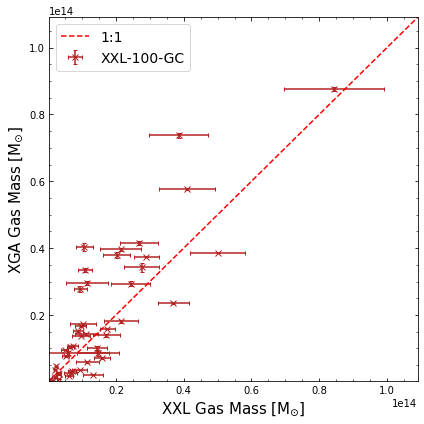

In [33]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_dblbeta_svikh_1r500_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_dblbeta_svikh_1r500_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_dblbeta_svikh_1r500_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.legend(loc='best', fontsize=14)
# Saving and plotting the resulting figure
plt.tight_layout()
# plt.savefig("non_paper_figures/xxl_dblbeta_svikh_1.3r500_gm_comp.pdf")
plt.show()
plt.close('all')